# 3.A: Simplified analysis of T2K $\nu_e$ appearance data

Reference: [10.1103/PhysRevLett.121.171802](https://doi.org/10.1103/PhysRevLett.121.171802)

Use information from tables I and II only to form simplified posteriors for $\sin\delta_{CP}$ and mass ordering. These tables are shown below. The paper reports the posterior probability for normal ordering is 87%.

Table I: systematic uncertainties for far-detector event yields (%):
* $\nu_e$: 8.8
* $\nu_e \pi^+$: 18.4
* $\bar{\nu}_e$: 7.1

Assume that these are independent sources of systematic uncertainty.

Table II: far-detector event yields (expected and observed):
* Normal ordering:
  * $\nu_e$: $61.7 - 11.8\sin\delta_{CP}$
  * $\nu_e \pi^+$: $5.9 - 1.0\sin\delta_{CP}$
  * $\bar{\nu}_e$: $9.0 + 1.0\sin\delta_{CP}$
* Inverted ordering:
  * $\nu_e$: $54.2 - 10.7\sin\delta_{CP}$
  * $\nu_e \pi^+$: $5.2 - 1.0\sin\delta_{CP}$
  * $\bar{\nu}_e$: $9.8 + 1.2\sin\delta_{CP}$
* Observed:
  * $\nu_e$: 74
  * $\nu_e \pi^+$: 15
  * $\bar{\nu}_e$: 7

The extracted functional dependence from Table II data assumes a linear dependence on $\sin\delta_{CP}$. Ignore the other physics systematic parameters.

Use the MCMC approach to explore the posterior probability for the 5 parameters:
 - mass ordering (mo)
 - $\sin\delta_{CP}$ (sdcp)
 - scaling parameters for the 3 expected yields


In [1]:
# Import modules

import numpy as np
from trisep.MarkovChain import MarkovChain

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd

In [2]:
# Calculate the log posterior probability for a set of parameters:

# systematic uncertainties (scale factor)
nue_sys = 0.088
nuepi_sys = 0.184
nuebar_sys = 0.071

# observed numbers of events
nue_obs = 74
nuepi_obs = 15
nuebar_obs = 7

def logPosterior(pars):
    mo = pars['mo'] # mass ordering >0. = normal, <0. = inverted
    sdcp = pars['sdcp'] # sin(delta_CP)
    scale_nue = pars['scale_nue'] # scaling factor for nue expectation
    scale_nuepi = pars['scale_nuepi'] # scaling factor 
    scale_nuebar = pars['scale_nuebar'] # scaling factor

    # expectation values for the 3 measurements:
    
    nue_exp = (61.7 - 11.8*sdcp)*scale_nue
    nuepi_exp = (5.9 - 1.0*sdcp)*scale_nuepi
    nuebar_exp = (9.0 + 1.0*sdcp)*scale_nuebar
    
    if mo < 0:
        nue_exp = (54.2 - 10.7*sdcp)*scale_nue
        nuepi_exp = (5.2 - 1.0*sdcp)*scale_nuepi
        nuebar_exp = (9.8 + 1.2*sdcp)*scale_nuebar
        
    # Calculate the log likelihood for this set of parameters
    # Use Poisson distribution
    logLt2k = nue_obs * np.log(nue_exp) - nue_exp + nuepi_obs * np.log(nuepi_exp) - nuepi_exp + nuebar_obs * np.log(nuebar_exp) - nuebar_exp

    # Priors for mo and sdcp are uniform - no need to include these terms in the prior

    # Calculate the log priors for systematic parameters (Gaussian)
    logPrior = -0.5 * ( ((scale_nue - 1)/nue_sys)**2 + ((scale_nuepi - 1)/nuepi_sys)**2 + ((scale_nuebar - 1)/nuebar_sys)**2 )

    # consider prior with delta uniform (instead of sin(delta) uniform)
    # pi(s) ds = pi(d) dd -> pi(s) = const * |ds/dd|^-1
    #logPrior += np.log(1./np.sqrt(1-sdcp**2+0.000001))
    # return the log Posterior probability (no need to be normalized)
    return logLt2k + logPrior

# MCMC

n_MCMC = 100000

parameters = [
    {'name':'mo','start':0.5,'step':0.2,'min':-1.,'max':1.},
    {'name':'sdcp','start':0.,'step':0.1,'min':-1.,'max':1.},
    {'name':'scale_nue','start':1.,'step':0.3*nue_sys,'min':0.,'max':10.},
    {'name':'scale_nuepi','start':1.,'step':0.3*nuepi_sys,'min':0.,'max':10.},
    {'name':'scale_nuebar','start':1.,'step':0.3*nuebar_sys,'min':0.,'max':10.}
]

mcmc = MarkovChain(parameters, logPosterior)
chain = mcmc.get_chain(n_MCMC)

Acceptance fraction: 0.74992


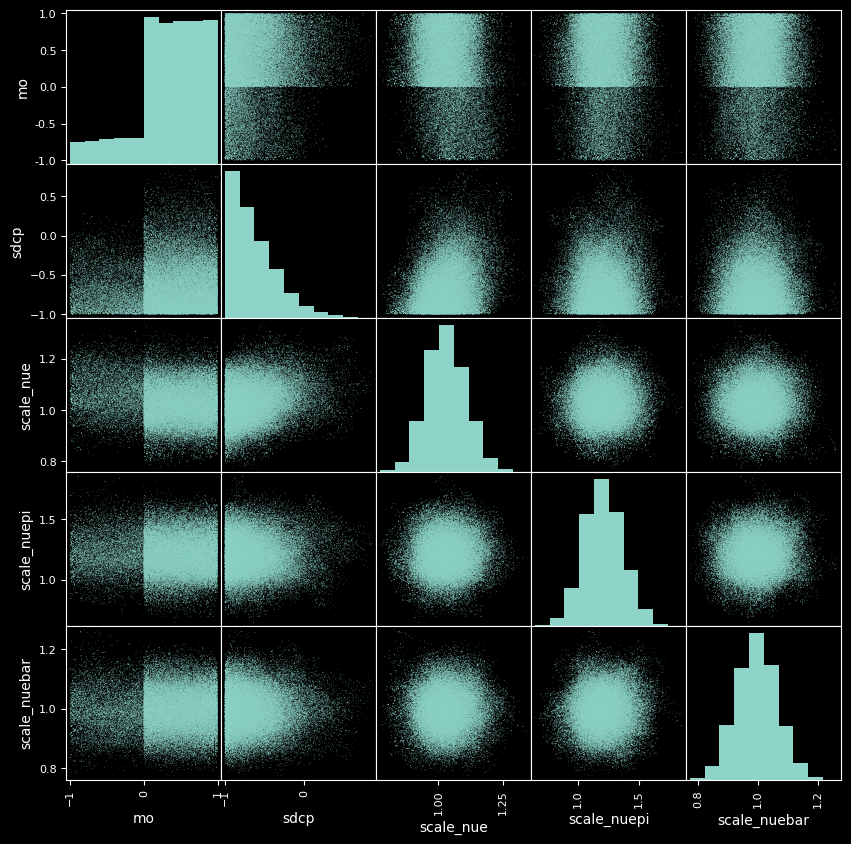

In [3]:
# Look at  all 1D and 2D projections

dfc = pd.DataFrame(chain)
pd.plotting.scatter_matrix(dfc,s=1,figsize=[10,10]);

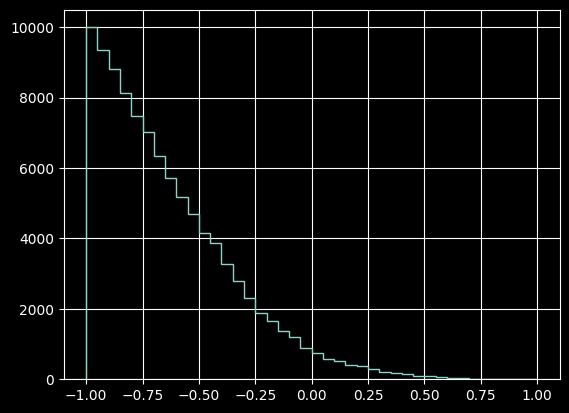

Fraction of points with sindcp > 0 = 0.038
Fraction of points with normal ordering = 0.855 (publication: 0.87)


In [4]:
dfc['sdcp'].hist(bins=np.arange(-1.,1.01,0.05),histtype='step')
plt.show()
print("Fraction of points with sindcp > 0 = {0:5.3f}".format(1.*len(dfc[dfc.sdcp > 0.])/len(dfc)))
print("Fraction of points with normal ordering = {0:5.3f} (publication: 0.87)".format(1.*len(dfc[dfc.mo > 0])/len(dfc)))

In [ ]:
# Consider an alternative prior for CP violation parameter. Uniform in delta, instead of uniform in sin(delta). 